In [109]:
import numpy as np
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import tensorflow.keras as keras
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Add,Concatenate, MaxPooling2D,Activation, Dense, Flatten, Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, Conv2DTranspose
from PIL import Image, ImageOps
import os
import pathlib
from tensorflow.keras.callbacks import LearningRateScheduler

# Data

In [110]:
BATCH_SIZE = 32
SIZE = 224
EPOCH= 100
NB_CLASSES = 70

In [112]:
classes = ['Ford Focus Sedan 2007', 'BMW 3 Series Wagon 2012',
       'Jeep Liberty SUV 2012', 'Volvo C30 Hatchback 2012',
       'Chrysler Crossfire Convertible 2008', 'Chrysler 300 SRT-8 2010',
       'Audi A5 Coupe 2012', 'Chevrolet Corvette ZR1 2012',
       'Chevrolet Silverado 1500 Classic Extended Cab 2007',
       'AM General Hummer SUV 2000', 'Hyundai Sonata Sedan 2012',
       'Toyota Camry Sedan 2012', 'Nissan Leaf Hatchback 2012',
       'Audi S5 Convertible 2012', 'Fisker Karma Sedan 2012',
       'Chevrolet Silverado 1500 Extended Cab 2012',
       'Scion xD Hatchback 2012', 'Mitsubishi Lancer Sedan 2012',
       'Cadillac SRX SUV 2012', 'Maybach Landaulet Convertible 2012',
       'Chevrolet Camaro Convertible 2012',
       'Lamborghini Reventon Coupe 2008', 'Honda Odyssey Minivan 2012',
       'Audi TT RS Coupe 2012', 'Audi S5 Coupe 2012',
       'Ford Expedition EL SUV 2009', 'BMW 1 Series Convertible 2012',
       'Bentley Continental GT Coupe 2007', 'Hyundai Veracruz SUV 2012',
       'Acura ZDX Hatchback 2012']

In [113]:
len(classes)

30

In [114]:
from sklearn.model_selection import train_test_split

def split_database(chemin, proba_train):
    x         = []
    y         = []
    for l in glob.glob(chemin+"*.jpg"):
        x.append(l)
        label = l.split("_")[-2].split("/")[1]
        for j in range(len(classes)):
            if classes[j] == label :
                y.append(j)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=proba_train, random_state=42)
    return [X_train, y_train], [X_test, y_test]

chemin = "../datasets/datasets_train/car_models_database_train/"
train_database, val_database = split_database(chemin, 0.1)

In [115]:
print(len(train_database[0]), len(val_database[0]))

352 40


In [130]:
def read_function(filename, label):
    image  = tf.image.decode_jpeg(tf.io.read_file(filename), channels=3)
    image = tf.image.resize(image, (SIZE,SIZE), method= tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False)
    return image, label

def create_dataset(data):
  images = tf.constant(data[0]) 
  labels = tf.constant(data[1]) 
  dataset =  tf.data.Dataset.from_tensor_slices((images, labels))
  dataset  = dataset.map(read_function, num_parallel_calls=tf.data.AUTOTUNE) #.cache()
  dataset  = dataset.shuffle(buffer_size =len(data[0])).prefetch(buffer_size=2) 
  dataset  = dataset.batch(BATCH_SIZE, drop_remainder=True)

  return dataset  

gen_train = create_dataset(train_database)
gen_val = create_dataset(val_database)

In [132]:
gen_train.as_numpy_iterator

<bound method DatasetV2.as_numpy_iterator of <BatchDataset shapes: ((24, 224, 224, 3), (24,)), types: (tf.float32, tf.int32)>>

In [133]:
def get_batch_random(batch_size,s="train"):
    """
    Cree des batchs de triplets APN avec une stratégie aleatoire    
    Entrée:
    batch_size -- int

    Sortie:
    triplets -- liste A,P,N avec les dimensions (batch_size,w,h,c)
    """
    if s == 'train':
        X = train_database
    else:
        X = val_database

    w = h = SIZE
    c = 3
    
    
    # initialisation de la liste de sortie
    triplets=[np.zeros((batch_size,h, w,c)) for i in range(3)]
    
    for i in range(batch_size):
        #Liste temporaire pour les images A et P
        AP = []
        #S'assurer que la liste contient au moins 2 elements
        while(len(AP)<2):
          #Prendre une classe aléatoirement
          anchor_class = np.random.randint(0, NB_CLASSES)
          for j in range(len(X[1])):
            if X[1][j] == anchor_class:
              AP.append(X[0][j])
        
        nb_sample_available_for_class_AP = len(AP)

        
        #Prendre deux images de cette classe (A et P)
        [idx_A,idx_P] = np.random.choice(nb_sample_available_for_class_AP,size=2,replace=False)
        
        
        #Liste temporaire pour les images N de la classe anchor_class
        N=[]
        #S'assurer que la liste contient au moins 1 element
        while(len(N)<1):
          #Prendre une image d'une classe differente de anchor_class pour N
          negative_class = (anchor_class + np.random.randint(1,NB_CLASSES)) % NB_CLASSES
          for j in range(len(X[1])):
              if X[1][j] == negative_class:
                N.append(X[0][j])
        nb_sample_available_for_class_N = len(N)

        #Prendre une image aleatoirement pour l'image negative N
        idx_N = np.random.randint(0, nb_sample_available_for_class_N)
        #Ouvrir les image A, P, et N et les ajouter dans triplets

        
        A  = tf.image.decode_jpeg(tf.io.read_file(AP[idx_A]), channels=3)
        A = tf.image.resize(A, (SIZE,SIZE), method= tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False)

        P  = tf.image.decode_jpeg(tf.io.read_file(AP[idx_P]), channels=3)
        P = tf.image.resize(P, (SIZE,SIZE), method= tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False)

        N  = tf.image.decode_jpeg(tf.io.read_file(N[idx_N]), channels=3)
        N = tf.image.resize(N, (SIZE,SIZE), method= tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False)


        triplets[0][i,:,:,:] = A
        triplets[1][i,:,:,:] = P
        triplets[2][i,:,:,:] = N

    return triplets

def drawTriplets(tripletbatch, nbmax=None):
    """
    Afficher les triplets
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            plt.axis("off")
            plt.imshow(np.squeeze(np.array(tripletbatch[i][row,:,:,:]).astype(int)))
            subplot.title.set_text(labels[i])

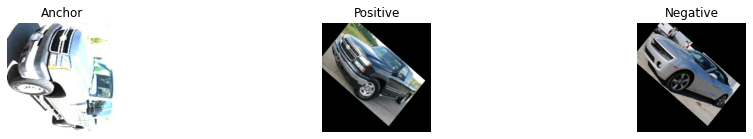

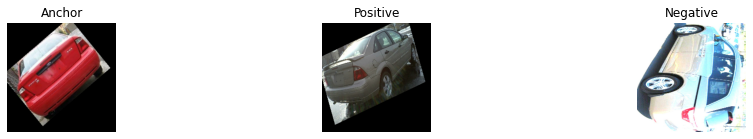

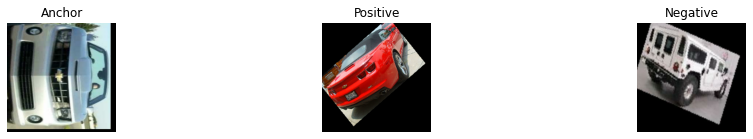

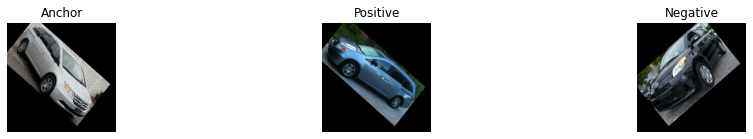

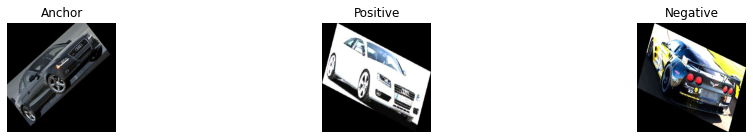

In [134]:
batch = get_batch_random(16)
drawTriplets(batch, 5)

In [157]:
from keras import initializers
from tensorflow.keras import  layers, models

def createModel(prefix, out=256):
  model = models.Sequential()
  model.add(tf.keras.Input(shape=(SIZE,SIZE,3)))

  
  model.add(layers.Conv2D(kernel_size=3, filters=64, strides=1, padding="same", name=prefix+"Conv0"))
  model.add(layers.LeakyReLU())
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
  model.add(layers.Conv2D(kernel_size=3, filters=128, padding="same", name=prefix+"Conv1"))
  model.add(layers.LeakyReLU())
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
  model.add(layers.Conv2D(kernel_size=3, filters=256, padding="same", name=prefix+"Conv2"))
  model.add(layers.LeakyReLU())
  model.add(layers.GlobalAveragePooling2D(name="gp"))
  
  model.add(layers.Dense(2048, use_bias=True, bias_initializer=initializers.Constant(0.1), name=prefix+"FC0"))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(2048, use_bias=True, bias_initializer=initializers.Constant(0.1), name=prefix+"FC1"))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(out, activation='tanh', name=prefix+"FC2"))
  model.add(layers.Lambda(lambda x: tf.math.l2_normalize(x,axis=-1)))

  return model

In [158]:
class TripletLossLayer(keras.layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs

        d_pos = tf.reduce_mean(tf.square(anchor - positive), -1) # On cherche à optimiser cette partie
        d_neg = tf.reduce_mean(tf.square(anchor - negative), -1)
        #tf.print(d_pos)
        #tf.print(d_neg)
        loss = tf.maximum(self.alpha + d_pos - d_neg, 0.0)

        return loss
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [159]:
def build_model(input_shape, network, margin=.5):
    # Definir les trois entrees (A, P, et N)
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generer les trois vecteurs caracteristiques
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #Calcul de la TripletLoss
    loss_layer = TripletLossLayer(alpha=margin,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    return network_train

In [160]:
import time

def data_generator(batch_size=256):
  while True:
    x = get_batch_random(batch_size)
    yield x

def loss_red(y_true, y_pred):
    return tf.math.reduce_sum(y_pred)

def step_decay(epoch):
  if epoch<int(EPOCH//2+1):
    return 0.000001
  elif epoch<int(EPOCH*2//3+1):
    return 0.0000001
  else:
    return 0.00000001
lrate = LearningRateScheduler(step_decay, verbose=1)

BATCH_SIZE = 24
EPOCH = 20

network = createModel("Triplet", out=1024)
network_train = build_model((SIZE, SIZE, 3), network)
optimizer = tf.keras.optimizers.RMSprop(lr = 0.000001)
network_train.compile(loss=loss_red,optimizer=optimizer)
network_train.summary()
steps_per_epoch = int(len(train_database[0])/BATCH_SIZE)

history_triplet = network_train.fit(data_generator(BATCH_SIZE), steps_per_epoch=steps_per_epoch, 
                                    epochs=EPOCH, verbose=True, callbacks=[lrate])


/opt/conda/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                          

ValueError: in user code:

    File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.8/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_4" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>]


In [161]:
!pip install -q -U tensorflow-addons

In [145]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(SIZE, SIZE, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [146]:
import tensorflow_datasets as tfds

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [175]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',])

In [176]:
gen_train

<BatchDataset shapes: ((24, 224, 224, 3), (24,)), types: (tf.float32, tf.int32)>

In [178]:
model.fit(gen_train, epochs=15, batch_size=24)

Epoch 1/15
14/14 [==============================] - 1s 22ms/step - loss: 4.9032 - accuracy: 0.9554
Epoch 2/15
14/14 [==============================] - 1s 22ms/step - loss: 4.8327 - accuracy: 0.9911
Epoch 3/15
14/14 [==============================] - 1s 21ms/step - loss: 4.7887 - accuracy: 1.0000
Epoch 4/15
14/14 [==============================] - 1s 22ms/step - loss: 4.7428 - accuracy: 1.0000
Epoch 5/15
14/14 [==============================] - 1s 24ms/step - loss: 4.7013 - accuracy: 1.0000
Epoch 6/15
14/14 [==============================] - 1s 20ms/step - loss: 4.6746 - accuracy: 1.0000
Epoch 7/15
14/14 [==============================] - 1s 21ms/step - loss: 4.6659 - accuracy: 1.0000
Epoch 8/15
14/14 [==============================] - 1s 20ms/step - loss: 4.6424 - accuracy: 1.0000
Epoch 9/15
14/14 [==============================] - 1s 20ms/step - loss: 4.6260 - accuracy: 1.0000
Epoch 10/15
14/14 [==============================] - 1s 21ms/step - loss: 4.6149 - accuracy: 1.0000
Epoch 11/

In [165]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [167]:
!pip install -q -U tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 23.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 KB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 17.8 MB/s eta 0:00:00


In [172]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(SIZE,SIZE,3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

In [173]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [174]:
history = model.fit(
    train_database,
    epochs=5)

Epoch 1/5


ValueError: in user code:

    File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_20" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 352)
